In [2]:
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.distributions import constraints
import seaborn as sns
from torch import nn
import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import pycaret



pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [18]:
from sklearn.model_selection import train_test_split

#Read in the data, convert nulls to 0

df_bb = pd.read_csv("2015_2019_NCAATrain.csv")
df_bb['game_id'] = df_bb.index

df_bb['efficiency_diff'] = df_bb['AdjOEDiff']+df_bb['AdjDEDiff']

features = ['proj_line','is_home','is_neutral','is_away','AdjOEDiff','AdjDEDiff','TRankDiff','efficiency_diff','TalentDiff',
           'ExpDiff','Eff_HeightDiff']

# features=['proj_line', 'RankDiff', 'AdjOEDiff', 'AdjDEDiff', 'TRankDiff', 'EFG%Diff',
#        'EFGD%Diff', 'TORDiff', 'TORDDiff', 'ORBDiff', 'DRBDiff', 'FTRDiff',
#        'FTRDDiff', '2P%Diff', '2P%DDiff', '3P%Diff', '3P%DDiff', 'AdjTDiff',
#        'WABDiff', 'Avg_HeightDiff', 'Eff_HeightDiff', 'TalentDiff', 'ExpDiff',
#        'AdjOvsOppAdjD', 'AdjDvsOppAdjO', 'EFGvsOppEFGD', 'EFGDvsOppEFG',
#        'TORvsOppTORD', 'TORDvsOppTOR', 'ORBvsOppDRB', 'DRBvsOppORB',
#        'FTRvsOppFTRD', 'FTRDvsOppFTR']

df_bb=df_bb.fillna(value=0)
df_bb
df_bb['game_id'] = df_bb.index
#split train/test and make some tensors
train_id, test_id = train_test_split(list(df_bb.game_id.unique()), test_size=.2)
train = df_bb[df_bb.game_id.isin(train_id)]
test = df_bb[df_bb.game_id.isin(test_id)]

#For predicting if game is a win - categorical output
#y_train = torch.from_numpy(train['is_win'].to_numpy().squeeze()).float()

#For predicting game spread
y_train = torch.from_numpy(train['score_diff'].to_numpy().squeeze()).float()
x_train = torch.from_numpy(train[features].to_numpy().squeeze()).float()


#make sure we don't have any NaN in our training data, otherwise we'll see NaN in epoch loss
assert not (torch.isnan(x_train).any())

print(f'{len(train_id)} games used for training. {len(test_id)} games used for testing.')



41769 games used for training. 10443 games used for testing.


11

In [20]:
class ThreeLayerNNModelContinuous(PyroModule):
    #Simple three layer model, hidden layer structure controlled by h1,h2,h3
    def __init__(self, in_features, out_features, h1, h2, h3):
        super().__init__()
        #set priors for layer weight and bias, using a normal distribution centered at 0
        self.fc1 = PyroModule[nn.Linear](in_features, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, in_features]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([h1]).to_event(1))
        #set priors for layer weight and bias, using a normal distribution centered at 0
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 10.).expand([h2]).to_event(1))
        #set priors for layer weight and bias, using a normal distribution centered at 0
        self.fc3 = PyroModule[nn.Linear](h2, h3)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([h3, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 10.).expand([h3]).to_event(1))
        #set priors for layer weight and bias, using a normal distribution centered at 0
        self.fc4 = PyroModule[nn.Linear](h3, out_features)
        self.fc4.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, h3]).to_event(2))
        self.fc4.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        #set ReLU activation functions for each layer 
        x1 = self.relu(self.fc1(x).squeeze(-1))
        x2 = self.relu(self.fc2(x1).squeeze(-1))
        x3 = self.relu(self.fc3(x2).squeeze(-1))
        
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.fc4(x3).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean



In [21]:
class ThreeLayerNNModelCategorical(PyroModule):
    #Simple three layer model, hidden layer structure controlled by h1,h2,h3
    def __init__(self, in_features, out_features, h1, h2, h3):
        super().__init__()
        #set priors for layer weight and bias, using a normal distribution centered at 0
        self.fc1 = PyroModule[nn.Linear](in_features, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, in_features]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([h1]).to_event(1))
        #set priors for layer weight and bias, using a normal distribution centered at 0
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 10.).expand([h2]).to_event(1))
        #set priors for layer weight and bias, using a normal distribution centered at 0
        self.fc3 = PyroModule[nn.Linear](h2, h3)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([h3, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 10.).expand([h3]).to_event(1))
        #set priors for layer weight and bias, using a normal distribution centered at 0
        self.fc4 = PyroModule[nn.Linear](h3, out_features)
        self.fc4.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, h3]).to_event(2))
        self.fc4.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        #define some functions here for use later
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        #set ReLU activation functions for each layer 
        x1 = self.relu(self.fc1(x).squeeze(-1))
        x2 = self.relu(self.fc2(x1).squeeze(-1))
        x3 = self.relu(self.fc3(x2).squeeze(-1))
        p = self.sigmoid(self.fc4(x3).squeeze(-1))
        with pyro.plate("data", x.shape[0]):
                  obs=pyro.sample("obs", dist.Bernoulli(p), obs=y)
        return p
        
        


In [22]:
def inference(model, features=None, batch_size=1000, lr=0.001, epochs=10):
    pyro.clear_param_store()
    #Set our SVI guide, we're just using an auto guide here. 
    guide = AutoDiagonalNormal(model)
    #Set our activation fnction
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    num_samples = len(y_train)
    #load up our data, shuffle, and batch that stuff
    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                               batch_size=batch_size, shuffle=True)

    losses = []
    loss = 0
    epoch_loss = 0
    for epoch in range(epochs):
        for i, (xiter, yiter) in enumerate(train_loader):
            #Progress 1 step forward and calculate loss
            loss = svi.step(xiter, yiter)
            if i % (round(num_samples / batch_size / 10)) == 0:
                losses.append(loss / batch_size)
                print(f"*", end=' ')
        print(f"epoch {epoch + 1}: {loss / batch_size}")
    return losses, guide


* * * * * * * * * * * epoch 1: 8.746630429983139
* * * * * * * * * * * epoch 2: 7.0174973802566525
* * * * * * * * * * * epoch 3: 6.38297087097168
* * * * * * * * * * * epoch 4: 5.6804355602264405
* * * * * * * * * * * epoch 5: 6.2903224487304685
* * * * * * * * * * * epoch 6: 4.937959091186523
* * * * * * * * * * * epoch 7: 4.939507447242737
* * * * * * * * * * * epoch 8: 5.475219102025032
* * * * * * * * * * * epoch 9: 5.356935219168663
* * * * * * * * * * * epoch 10: 4.8631558611392975
* * * * * * * * * * * epoch 11: 4.086933074235916
* * * * * * * * * * * epoch 12: 4.843147711753845
* * * * * * * * * * * epoch 13: 4.173389246225357
* * * * * * * * * * * epoch 14: 4.379261499404907
* * * * * * * * * * * epoch 15: 3.9606383209228517
* * * * * * * * * * * epoch 16: 4.768013859987259
* * * * * * * * * * * epoch 17: 3.982540976524353
* * * * * * * * * * * epoch 18: 4.945977957129479
* * * * * * * * * * * epoch 19: 3.9837817162275315
* * * * * * * * * * * epoch 20: 3.9758819530010223
* *

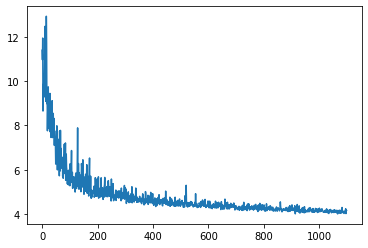

In [23]:
#features = ['proj_line','is_home','is_neutral','is_away','adjo_diff','adjd_diff','trank_diff','efficiency_diff']
model = ThreeLayerNNModelContinuous(11, 1, 11, 15, 11)
losses, guide = inference(model, features=features, epochs=100)
plt.plot(losses)

In [24]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [33]:
#features = ['proj_line','is_home','is_neutral','is_away','adjo_diff','adjd_diff','trank_diff','efficiency_diff']

#sample data from posterior, simulate changing one variable while holding everything else constant
guide.requires_grad_(False)
ptups = {}
multiplier=2
for change in np.arange(-5,6):
    #['proj_line','is_home','is_neutral','is_away','AdjOEDiff','AdjDEDiff','TRankDiff','efficiency_diff','TalentDiff','ExpDiff','Eff_HeightDiff']
    inc_change=change*multiplier
    x = torch.Tensor([0,1,0,0,0,0,0,inc_change,0,0,0])
    #Sample from posterior distribution and dump into a big dataframe
    predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("obs","_RETURN"))
    predictions = predictive(x)
    ptups[inc_change] = [float(p) for p in predictions['_RETURN']]

ptups_df = pd.DataFrame.from_dict(ptups)
pred_df = pd.melt(ptups_df,var_name='lead',value_name='prediction')
ptups_df.sample(frac=0.01).head(10)

,-10,-8,-6,-4,-2,0,2,4,6,8,10
603,1.082868,-0.505128,1.026239,-0.278009,0.547216,0.288032,-0.102689,1.531747,1.376589,0.837005,0.904748
697,0.769313,1.060871,-0.005827,-1.841728,0.750036,1.813487,0.847582,0.670445,1.410951,1.422902,3.021625
754,0.124927,-0.117895,0.362351,1.102562,-0.153087,-0.162309,0.941116,-1.234262,-0.675123,0.436217,-1.561797
967,1.421699,0.477619,0.061993,-1.362158,2.069305,1.901808,0.840593,0.439648,0.825513,3.729199,1.147448
172,0.075373,-0.181764,1.142288,0.803014,1.482943,0.859965,1.484333,0.593645,2.422594,0.015718,0.397528
654,1.309206,-1.128742,0.755670,0.904554,1.535473,1.582563,1.129835,3.207581,0.928238,2.451941,2.321416
78,-0.237094,-1.128668,0.710160,1.519361,1.333002,1.842964,1.163933,1.173216,1.427553,1.717484,2.010139
42,0.352057,0.469698,0.126045,0.108244,2.382258,-0.261343,1.257455,1.636963,0.222044,1.903550,1.351421
907,-0.620363,0.504252,0.791105,0.306003,0.487435,1.658977,0.692797,1.374533,2.195478,1.790707,3.599549
549,0.396593,-0.172852,-1.831573,-1.410257,-0.713650,3.411065,1.426773,1.608025,2.295059,2.576103,1.123450


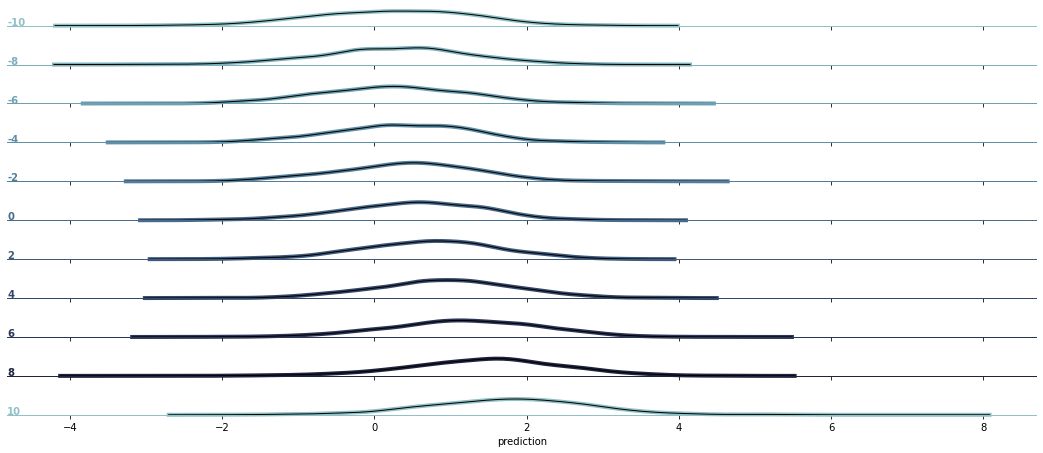

In [34]:
#make some nice posterior sampling distribution plots

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data=pred_df,row='lead',hue='lead',aspect=25,height=0.6,palette=pal)
g.map(sns.kdeplot, "prediction", clip_on=False, alpha=1, linewidth=4)
g.map(sns.kdeplot, "prediction", color="k", lw=1)
g.map(plt.axhline, y=0, lw=1, clip_on=False)
g.map(label, "prediction")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=1)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [35]:
#Test helper function to get our predictions
def eval_test(test_df, guide, features=None, num_samples=1000):
    x_test = torch.from_numpy(test_df[features].to_numpy().squeeze()).float()
    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=("obs","_RETURN"))
    samples = predictive(x_test)
    return summary(samples)

In [36]:
#Calculate predictions
guide.requires_grad_(False)
test_summary = eval_test(test, guide, features)
print(test_summary)

{'obs': {'mean': tensor([-18.0780,   5.8795,  10.3350,  ...,   2.3817,  -7.4953,  -3.3085]), 'std': tensor([7.6274, 6.7867, 7.1410,  ..., 7.0548, 6.9785, 7.1387]), '5%': tensor([-30.3302,  -4.8608,  -1.7102,  ...,  -9.0355, -19.4482, -15.4827]), '95%': tensor([-6.2393, 16.8890, 22.2328,  ..., 13.6358,  3.7419,  8.0176])}, '_RETURN': {'mean': tensor([-18.2782,   5.9347,  10.3862,  ...,   2.4585,  -7.3189,  -3.1870]), 'std': tensor([3.1350, 1.3559, 1.9031,  ..., 1.2910, 1.4602, 1.5223]), '5%': tensor([-23.7525,   3.8908,   7.5155,  ...,   0.3435,  -9.8307,  -5.7224]), '95%': tensor([-13.5641,   8.2683,  13.7832,  ...,   4.6634,  -4.9827,  -0.7685])}}


In [37]:
#get more prediction data
test['p_mean'] = test_summary['_RETURN']['mean']
test['5%'] = test_summary['_RETURN']['5%']
test['95%'] = test_summary['_RETURN']['95%']
test.head(20)

C:\Users\pscheetz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pscheetz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pscheetz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is try

,team,date,opponent,proj_line,score,opp_score,score_diff,is_win,is_noncon,is_con,...,2P%vsOpp2P%D,2P%DvsOpp2P%,3P%vsOpp3P%D,3P%DvsOpp3P%,Season,game_id,efficiency_diff,p_mean,5%,95%
2,Abilene Christian,2015-11-28,Oakland,-10.557800,57,85,-28,0,1,0,...,-6.4,1.1,6.0,-1.8,2015,2,-9.2,-18.278164,-23.752529,-13.564112
12,Abilene Christian,2016-01-19,McNeese St.,4.562140,75,67,8,1,0,1,...,-5.5,14.1,-2.1,7.0,2015,12,4.1,5.934739,3.890828,8.268338
21,Abilene Christian,2016-02-21,Southeastern Louisiana,7.257820,91,80,11,1,0,1,...,-3.0,5.9,-5.5,3.3,2015,21,-4.2,10.386200,7.515513,13.783229
27,Air Force,2015-11-22,Robert Morris,2.259280,64,52,12,1,1,0,...,0.5,-2.5,-21.9,-5.9,2015,27,-3.2,6.922783,4.601344,9.621006
36,Air Force,2016-01-06,Wyoming,-6.257600,52,64,-12,0,0,1,...,0.3,-1.3,-1.1,-4.5,2015,36,-11.3,-10.359975,-13.559355,-7.516511
37,Air Force,2016-01-09,Nevada,-12.096000,63,86,-23,0,0,1,...,2.6,2.7,-2.7,5.0,2015,37,-3.7,-16.187492,-20.580494,-12.308860
42,Air Force,2016-01-27,New Mexico,-9.247520,55,84,-29,0,0,1,...,-1.1,-2.9,1.4,-2.0,2015,42,-4.4,-16.874550,-21.685888,-12.806075
43,Air Force,2016-01-30,San Jose St.,-15.188700,54,75,-21,0,0,1,...,-2.5,0.1,-5.3,5.0,2015,43,-3.3,-20.060524,-25.454296,-15.348924
44,Air Force,2016-02-02,Wyoming,-3.844650,70,62,8,1,0,1,...,-2.4,1.3,-0.6,-0.8,2015,44,-7.0,-6.371823,-9.062871,-3.635441
48,Air Force,2016-02-16,UNLV,-0.640678,79,74,5,1,0,1,...,0.9,1.0,-0.3,1.3,2015,48,4.0,-4.929235,-10.755569,1.286228


In [41]:
#MAE for line prediction
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test.score_diff, test.p_mean)

5.683154695585948

C:\Users\pscheetz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


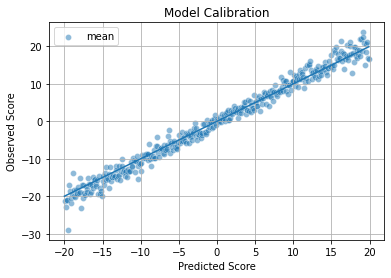

In [42]:
#model calibration chart
test['mean_bucket'] = pd.cut(test.p_mean, np.arange(-20,20,.1))
categories = test.mean_bucket.cat.categories
win_pct_bucket = test.groupby('mean_bucket').mean().score_diff
cal_df_mean = pd.DataFrame.from_records(list(zip(categories.right, win_pct_bucket)),columns=['tick','pct'])
g = sns.scatterplot(data=cal_df_mean,x='tick',y='pct',label='mean',alpha=0.5).grid()
plt.plot(np.arange(-20,20,.1),np.arange(-20,20,.1))
plt.title('Model Calibration')
plt.xlabel('Predicted Score')
plt.ylabel('Observed Score')
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
test['classification']=np.where(test['p_mean'] > 0, 1,0)

metrics.roc_auc_score(test.is_win, test.classification)

C:\Users\pscheetz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.8444866224937235

In [51]:
#Keeping this code here for classificationNN, not useful for spread prediction
#fpr, tpr, thresholds = metrics.roc_curve(test.is_win, test.classification)
#plt.plot(fpr, tpr)
#plt.plot(np.arange(0,1,.01),np.arange(0,1,.01))
#plt.xlabel('TPR')
#plt.ylabel('FPR')
#plt.grid()

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test.is_win, test.classification)

array([[4387,  831],
       [ 793, 4432]], dtype=int64)